In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import geopandas as gpd


pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 100


import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib import rc


import plotly.express as px

from paths import *
from scripts import vis_simulaCovid

## RT MAP

In [406]:
#load br cities
sp = gpd.read_file('../../brasil_geodata/maps/sp_municipios.json')
cols = ['geocodigo','nome_mesorregiao','geometry']
sp = sp[cols]

## SimulaCovid API ('http://datasource.coronacidades.org:7000/')
- br/states/rt
- br/cities/embaixadores
- br/cities/cnes
- world/owid/heatmap
- br/cities/farolcovid/main
- br/cities/rt
- br/cities/simulacovid/main
- br/cities/cases/full
- br/states/farolcovid/main


In [407]:
#load data
url  = 'http://datasource.coronacidades.org:7000/'
data = 'br/cities/farolcovid/main'

df = pd.read_csv(f'{url}{data}')

dd = df.merge(sp, how='right', left_on = 'city_id', right_on = 'geocodigo')
dd = gpd.GeoDataFrame(dd)


regiao = 'Vale do Paraíba Paulista'
mask = dd['nome_mesorregiao']==regiao
vale = dd[mask]

vale = gpd.GeoDataFrame(vale)

In [116]:
def plot_map(dd,var):
    fig = plt.figure(figsize=(25,25))
    ax  = fig.add_subplot(1,1,1)
    ax.set_title(f'{var}', fontsize=23)


    missings={
        "color": "white",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    }


    # dd.plot(column=var,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff",  scheme='user_defined', classification_kwds={'bins':[0.75,1]},missing_kwds=missings )
#     dd.plot(column=var,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff",  scheme='user_defined', classification_kwds={'bins':[10,100,500,1000,10000]},missing_kwds=missings )
#     dd.plot(column=var,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff",  scheme='user_defined', classification_kwds={'bins':[1,5,10,50,100,500,1000,3000]},missing_kwds=missings )
    dd.plot(column=var,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff",  scheme='user_defined', classification_kwds={'bins':[10,30,50,70]},missing_kwds=missings )

#     dd.plot(column=var ,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff" ,missing_kwds=missings, scheme='quantiles',k=30)

    ax.axis('off')


    plt.rc('legend',fontsize='large')

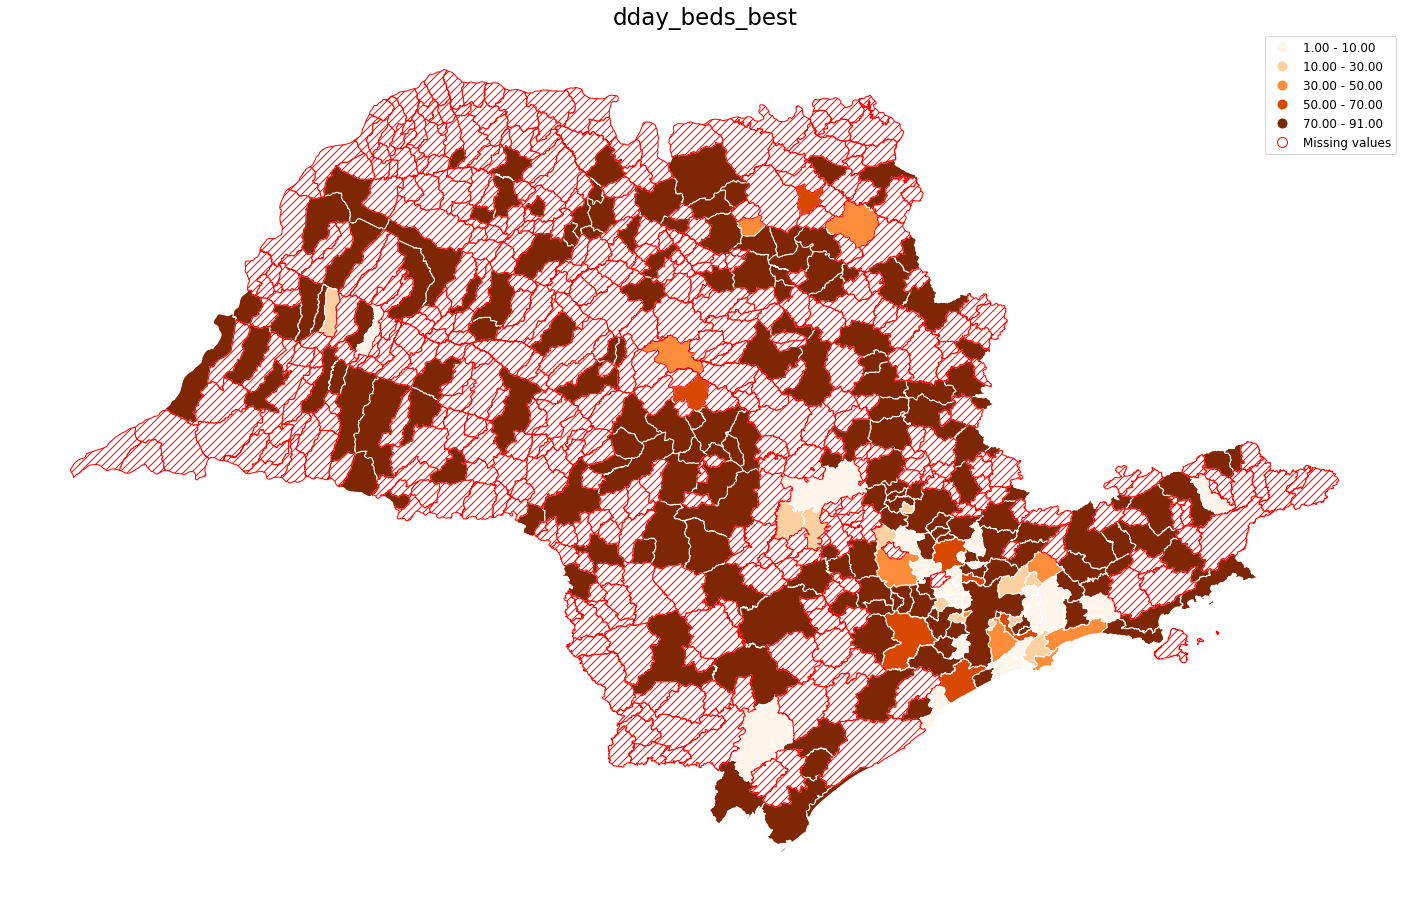

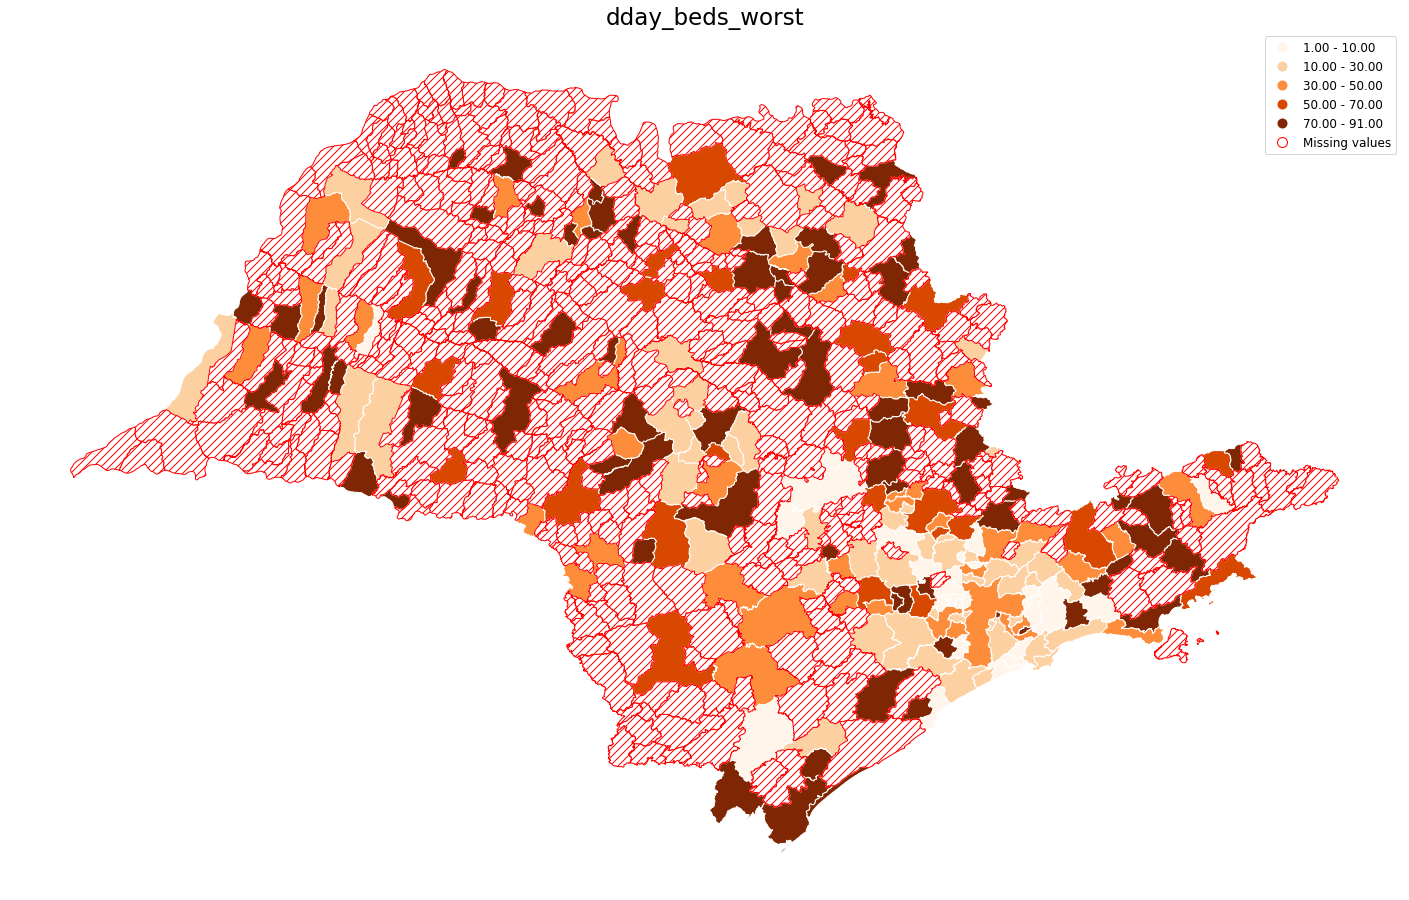

In [117]:
var = 'dday_beds_best'

plot_map(dd,var)


var = 'dday_beds_worst'

plot_map(dd,var)



# var = 'rt_10days_ago_avg'

# plot_map(dd,var)

# var = 'rt_ratio_week_avg'

# plot_map(dd,var)

### RT

In [2]:
#load br cities
geo_sp = gpd.read_file('../../brasil_geodata/maps/sp_municipios.json')
# cols = ['geocodigo','nome_mesorregiao','geometry']
cols = ['geocodigo','nome_mesorregiao','nome_municipio']
geo_sp = geo_sp[cols]

In [3]:
#load state data
url  = 'http://datasource.coronacidades.org:7000/'
data = 'br/states/rt'

ds = pd.read_csv(f'{url}{data}')

ds['last_updated'] = pd.to_datetime(ds['last_updated'])

sp = ds[ds['state']=='SP']
sp = sp.rename(columns={'state':'city_id'})
sp['nome_mesorregiao'] = 'SP'
sp['nome_municipio']   = 'Estado de SP'

rj = ds[ds['state']=='RJ']
rj = rj.rename(columns={'state':'city_id'})
rj['nome_mesorregiao'] = 'RJ'
rj['nome_municipio']   = 'Estado do RJ'

mg = ds[ds['state']=='MG']
mg = mg.rename(columns={'state':'city_id'})
mg['nome_mesorregiao'] = 'MG'
mg['nome_municipio']   = 'Estado de MG'

am = ds[ds['state']=='AM']
am = am.rename(columns={'state':'city_id'})
am['nome_mesorregiao'] = 'AM'
am['nome_municipio']   = 'Estado de AM'

In [10]:
#load cities data
url  = 'http://datasource.coronacidades.org:7000/'
data = 'br/cities/rt'

df = pd.read_csv(f'{url}{data}')

df['last_updated'] = pd.to_datetime(df['last_updated'])


dd = df.merge(geo_sp, how='right', left_on = 'city_id', right_on = 'geocodigo')
dd.head()

regiao = 'Vale do Paraíba Paulista'
mask = (dd['nome_mesorregiao']==regiao)
vale = dd[mask]
vale = vale[vale['city_id'].notnull()]

mask = (dd['nome_municipio']=='São Paulo')
sp_city = dd[mask]


vale = pd.concat([vale,sp_city], 0)
vale = pd.concat([vale,sp], 0)
vale = pd.concat([vale,rj], 0)
vale = pd.concat([vale,mg], 0)
# vale = pd.concat([vale,am], 0)

vale['nome_municipio'].unique()

array(['Aparecida', 'Bananal', 'Caçapava', 'Campos do Jordão',
       'Caraguatatuba', 'Cruzeiro', 'Cunha', 'Guaratinguetá', 'Igaratá',
       'Ilhabela', 'Jacareí', 'Jambeiro', 'Lorena', 'Paraibuna',
       'Pindamonhangaba', 'Potim', 'Roseira', 'Santa Branca',
       'Santo Antônio do Pinhal', 'São José dos Campos', 'São Sebastião',
       'Taubaté', 'Tremembé', 'Ubatuba', 'São Paulo', 'Estado de SP',
       'Estado do RJ', 'Estado de MG'], dtype=object)

In [11]:
def plot_rt_final(df_final,col,N_COLS):
    
    N_ROWS = int(np.ceil(len(df_final[col].unique()) / N_COLS))

    # opening figura
    fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(15, N_ROWS*3), dpi=400)

    for i, (city, result) in enumerate(df_final.groupby(col,sort=False)):
        ax = axes.flat[i]
        vis_simulaCovid.plot_rt(result, ax, city)
    fig.tight_layout()
    fig.set_facecolor('w')
    
    return fig

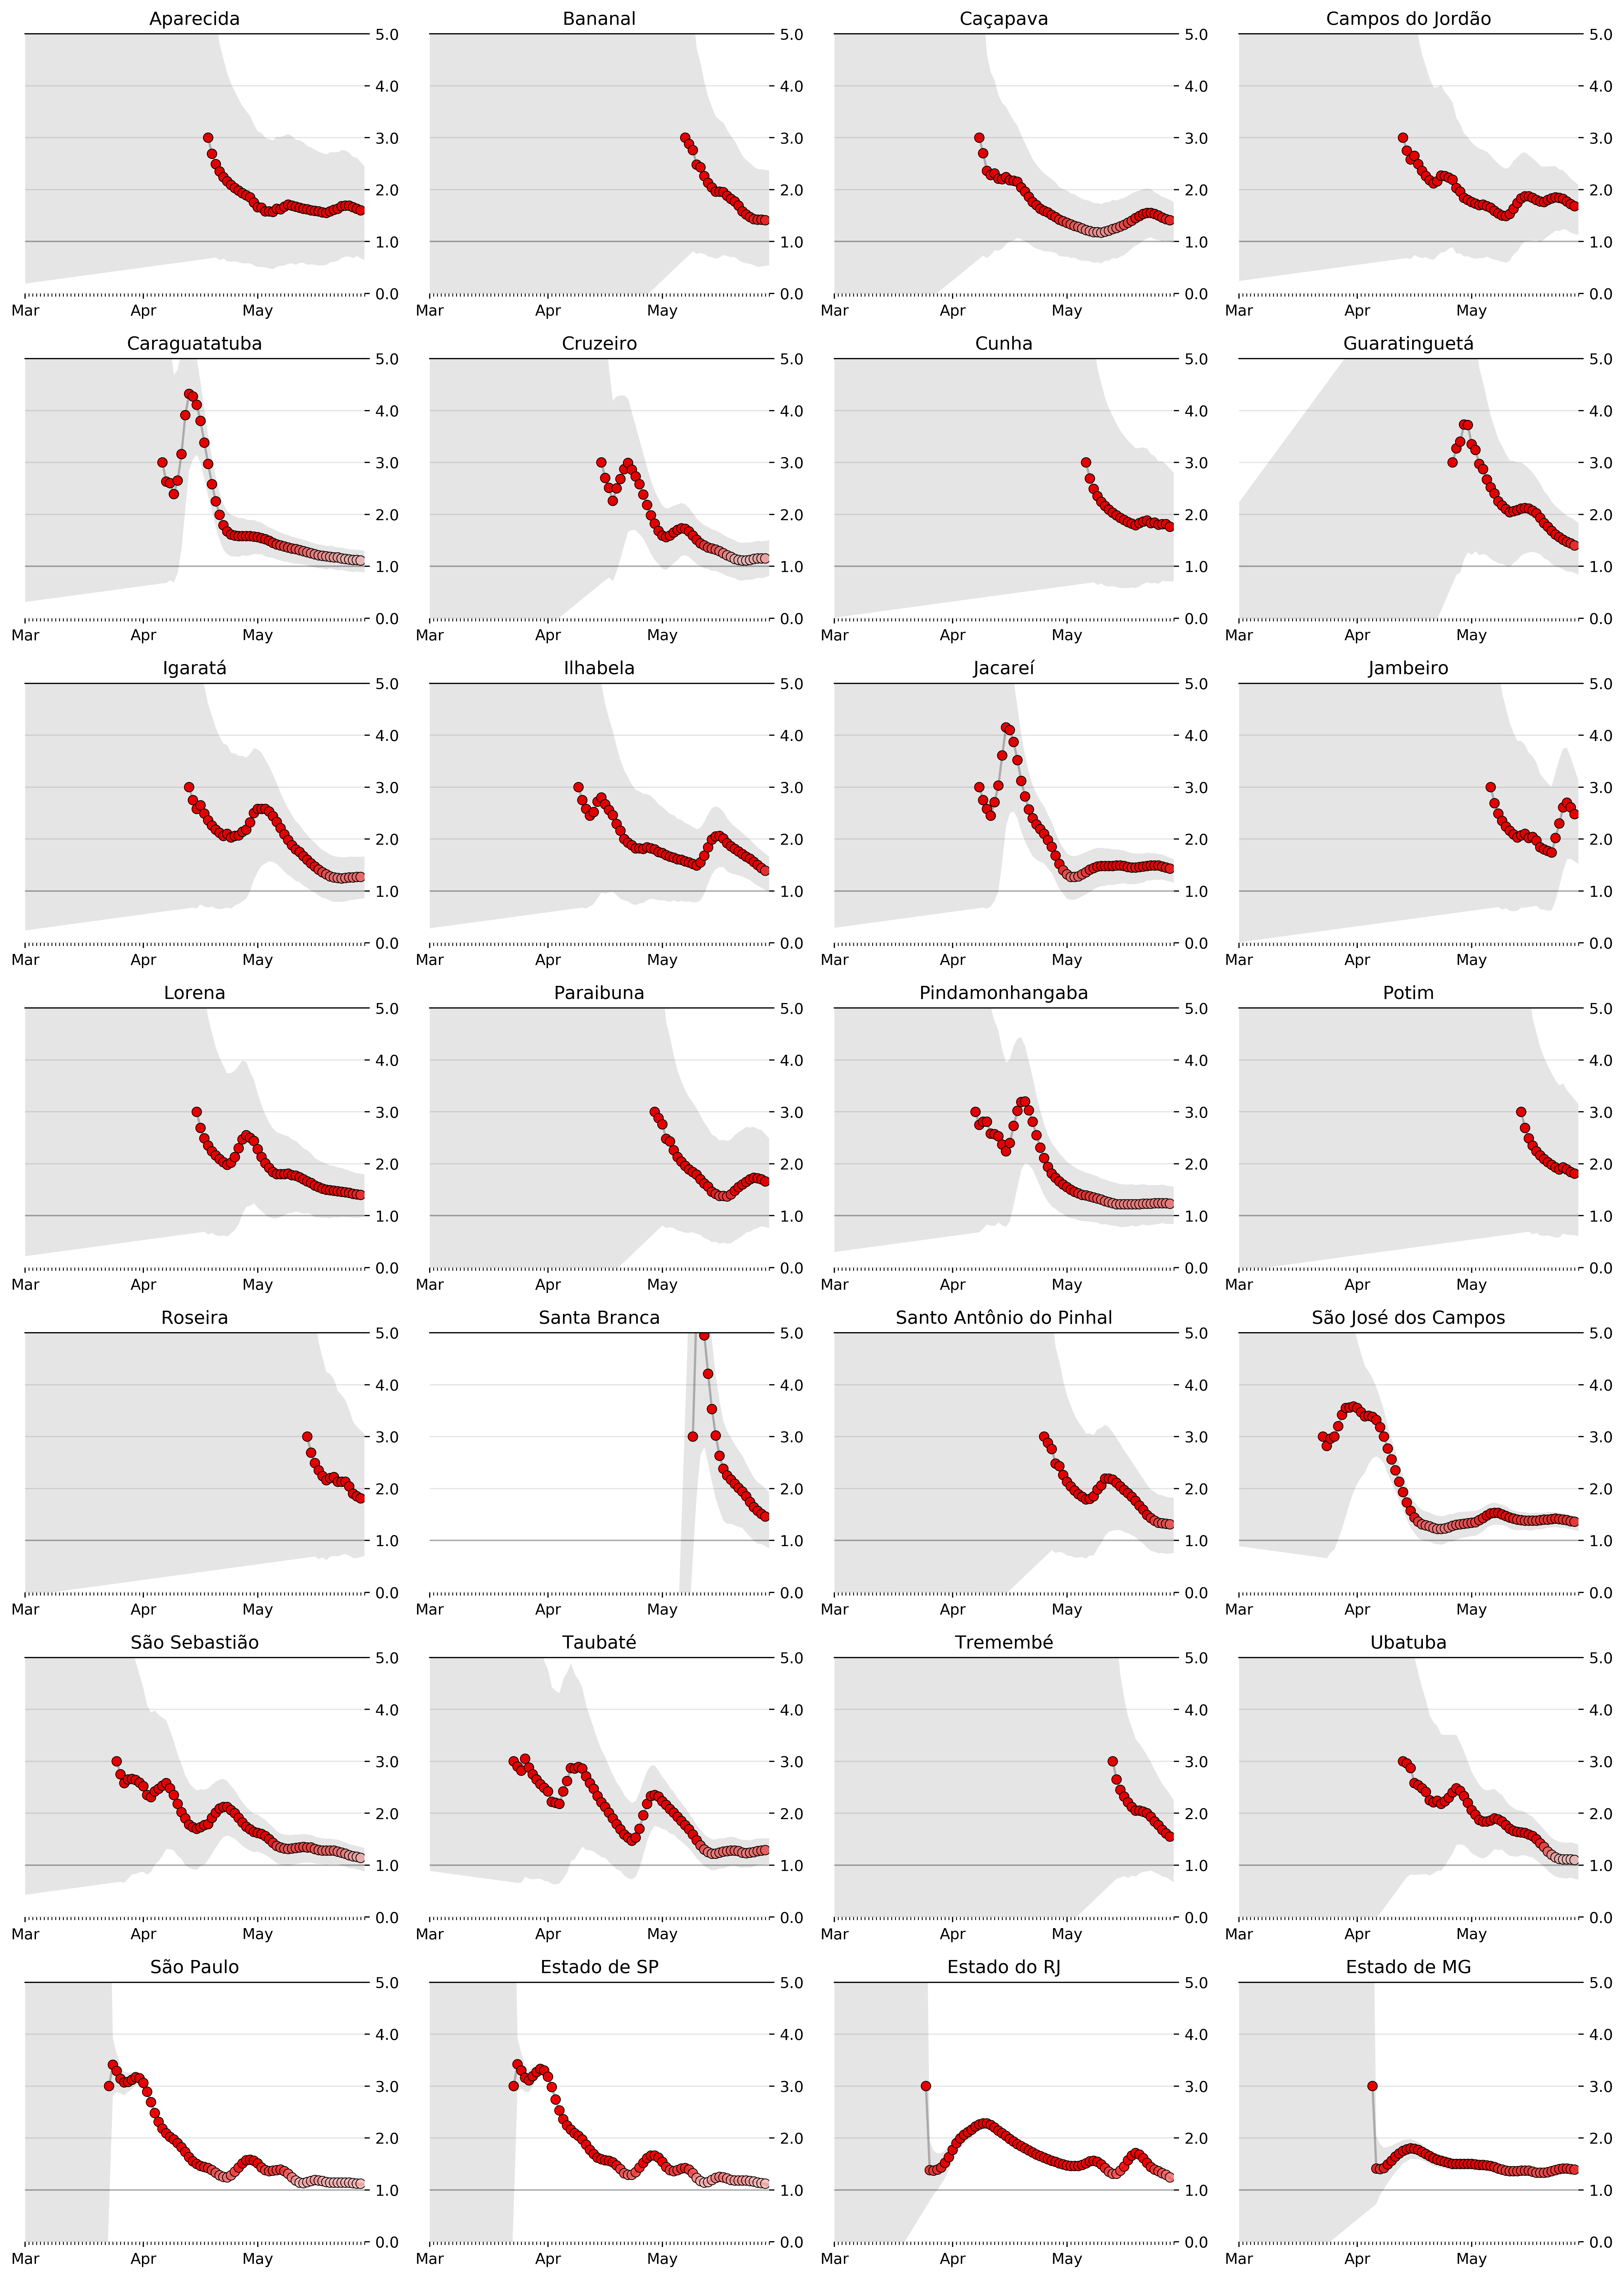

In [13]:
fig = plot_rt_final(vale,'nome_municipio',4)

fig.savefig("/home/m/Downloads/cidades.pdf", bbox_inches='tight')

In [14]:
fig = plot_rt_final(ds,'state',3)
fig.savefig("/home/m/Downloads/estados.pdf", bbox_inches='tight')